# Commodity Basket FX Strategy

**Outline**
1. Setup & Data Access
2. Feature Engineering
3. Alpha Signals
4. Backtest
5. Diagnostics & Attribution

## Packages

In [1]:
!pip install cvxpy

In [2]:
import os, sys, math, json, warnings, itertools, dataclasses
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'sklearn'

# 1. Setup & Data Access

In [3]:
# Load function for price (FX/Commodities) csv
def load_price_csv(file_path):
    data = pd.read_csv(file_path)
    # Processing Dates
    
    date_cols = None 
    if "Unnamed" in data.columns:
        date_cols = "Unnamed"
    elif "Date" in data.columns:
        date_cols = "Date"
    elif "DateTime" in data.columns:
        date_cols = "DateTime"
    elif "Date" in data.columns:
        date_cols = "Date"
    elif "date" in data.columns:
        date_cols = 'date'
    else:
        date_cols = data.columns[0]
    data[date_cols] = pd.to_datetime(data[date_cols],errors='coerce',dayfirst=True)
    data = data.dropna(subset=[date_cols])
    data = data.set_index(date_cols)

    # Processing Prices

    price_col = None
    for name in ['Close', 'Price', 'Last']:
        if name in data.columns:
            price_col = name
            break
        else:
            price_col = data.columns[-1]
    asset_name = file_path.stem
    price_series = data[price_col]
    price_series.name = asset_name
    price_series = pd.to_numeric(price_series,errors='coerce')

    return price_series

## 1.1 Commodities

In [4]:
# Load Commodity prices
base_path = Path("~/Desktop/Data/Commodities").expanduser()
dirs = ["Agriculture", "Energy", "Indicators", "Metals"]
all_series = []

for sub in dirs:
    folder = base_path / sub
    for file in folder.glob("*.csv"):
        series = load_price_csv(file)
        all_series.append(series)

all_data_df = pd.concat(all_series,axis=1)
all_data_df = all_data_df.resample('D').ffill()
all_data_df = all_data_df.ffill()
all_data_df = all_data_df.loc["2015-01-01":]

all_data_df.columns

Index(['Soybean', 'Lumber', 'Cheese', 'Milk', 'Plum Oil', 'Coffee', 'Rubber',
       'Wheat', 'Corn', 'Natural Gas', 'Uras_Oil', 'Ethanol', 'Brent',
       'Propane', 'TTF_Gas', 'German_Gas', 'Coal', 'UK_Gas', 'Uranium',
       'Methanol', 'Crude_Oil_WTI', 'Heating_Oil', 'Coking_Coal', 'Naphtha',
       'Gasoline', 'MSCI', 'EU_Carbon_Permits', 'GSCI', 'Wind_Energy_Index',
       'Containerized_Freight_Index', 'Solar_Energy_Index',
       'Nuclear_Energy_Index', 'LME', 'CRB_Index', 'SSE_Commodity',
       'Baltic_Dry_Index', 'Gold', 'Platinum', 'Steel', 'Silver', 'Silicon',
       'Lithium', 'Copper', 'HRC_Steel', 'Iron_ore', 'Titanium',
       'Iron_ore_CNY'],
      dtype='object')

## 1.2 Indicators

In [5]:
# Seperate Indicators from Commodities
indicator_cols = [
    'Baltic_Dry_Index', 'MSCI', 'Containerized_Freight_Index', 
    'CRB_Index', 'EU_Carbon_Permits', 'GSCI', 'LME', 
    'Nuclear_Energy_Index', 'Solar_Energy_Index', 'SSE_Commodity', 
    'Wind_Energy_Index'
]

indicator_df = all_data_df[indicator_cols].copy()
commodities_df = all_data_df.drop(columns=indicator_cols)

print(indicator_df.columns)
print(commodities_df.columns)

Index(['Baltic_Dry_Index', 'MSCI', 'Containerized_Freight_Index', 'CRB_Index',
       'EU_Carbon_Permits', 'GSCI', 'LME', 'Nuclear_Energy_Index',
       'Solar_Energy_Index', 'SSE_Commodity', 'Wind_Energy_Index'],
      dtype='object')
Index(['Soybean', 'Lumber', 'Cheese', 'Milk', 'Plum Oil', 'Coffee', 'Rubber',
       'Wheat', 'Corn', 'Natural Gas', 'Uras_Oil', 'Ethanol', 'Brent',
       'Propane', 'TTF_Gas', 'German_Gas', 'Coal', 'UK_Gas', 'Uranium',
       'Methanol', 'Crude_Oil_WTI', 'Heating_Oil', 'Coking_Coal', 'Naphtha',
       'Gasoline', 'Gold', 'Platinum', 'Steel', 'Silver', 'Silicon', 'Lithium',
       'Copper', 'HRC_Steel', 'Iron_ore', 'Titanium', 'Iron_ore_CNY'],
      dtype='object')


## 1.3 Macro Indices

In [6]:
# Load Macro Data
base_macro_path = Path("~/Desktop/Data/Macro").expanduser()
macro_files_to_load = {
    "PMI": [
        'China_Manufacture_PMI.csv',
        'US_Manufacture_PMI.csv',
        'Norway_Manufacture_PMI.csv',
        'NewZealand_Manufacture_PMI.csv',
        'SouthAfrica_Manufacture_PMI.csv'
    ],
    "Inflation": [
        'australia_cpi.csv',
        'canada_cpi.csv',
        'china_cpi.csv',
        'euro_cpi.csv',
        'new_zealand_cpi.csv',
        'norway_cpi.csv',
        'south_africa_cpi.csv',
        'us_cpi.csv',
        'us_core_inflation.csv'
    ],
    "Interest Rates": [
        'Australia_ir.csv',
        'Canada_ir.csv',
        'China_ir.csv',
        'Euro_ir.csv',
        'NewZealand_ir.csv',
        'Norway_ir.csv',
        'SouthAfrica_ir.csv',
        'US_ir.csv'
    ],
    "GDP": [
        'Australian_GDP.csv',
        'Canada_GDP.csv',
        'NewZealand_GDP.csv',
        'Norway_GDP.csv',
        'SouthAfrica_GDP.csv'
    ],
    "Trade_Data/Balance of Trade": [
        'australia_bot.csv',
        'canada_bot.csv',
        'china_bot.csv',
        'euro_bot.csv',
        'us_bot.csv'
    ],
    "Trade_Data/Terms of Trade": [
        'Australia_ToT.csv',
        'Canada_ToT.csv',
        'China_ToT.csv',
        'Germany_ToT.csv',
        'Newzealand_ToT.csv',
        'Norway_ToT.csv',
        'SouthAfrica_ToT.csv',
        'US_ToT.csv'
    ],
    "Imports": [
        'Australia_import.csv',
        'Canada_import.csv',
        'China_import.csv',
        'Euro_import.csv',
        'Norway_import.csv',
        'SouthAfrica_import.csv',
        'Newzealand_import.csv',
        'US_import.csv'
    ],
    "Exports": [
        'Australia_exports.csv',
        'Canada_exports.csv',
        'China_exports.csv',
        'Euro_exports.csv',
        'Norway_exports.csv',
        'SouthAfrica_exports.csv',
        'Newzealand_exports.csv',
        'US_exports.csv'
    ],
    "VIX_Data": [
        'USVIX.csv'
    ],
    "Retail Sales": [
        'Australia_retail.csv',
        'Canada_retail.csv',
        'China_retail.csv',
        'Euro_retail.csv',
        'Norway_retail.csv',
        'SouthAfrica_retail.csv',
        'Newzealand_retail.csv',
        'US_retail.csv'
    ]
}

macro_series = []
for sub, filenames in macro_files_to_load.items():
    for filename in filenames:
        fullpath = base_macro_path / sub / filename
        series = load_price_csv(fullpath)
        macro_series.append(series)

macro_df = pd.concat(macro_series,axis=1)
macro_df = macro_df.resample('D').ffill()
macro_df = macro_df.ffill()
macro_df = macro_df.loc["2015-01-01":]

macro_df.columns

/var/folders/n7/k_8ylm196lz3lzb72_x8vz340000gn/T/ipykernel_37429/4142338840.py:19: UserWarning: Parsing dates in %Y-%m-%dT%H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data[date_cols] = pd.to_datetime(data[date_cols],errors='coerce',dayfirst=True)
/var/folders/n7/k_8ylm196lz3lzb72_x8vz340000gn/T/ipykernel_37429/4142338840.py:19: UserWarning: Parsing dates in %Y-%m-%dT%H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data[date_cols] = pd.to_datetime(data[date_cols],errors='coerce',dayfirst=True)
/var/folders/n7/k_8ylm196lz3lzb72_x8vz340000gn/T/ipykernel_37429/4142338840.py:19: UserWarning: Parsing dates in %Y-%m-%dT%H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data[date_cols] = pd.to_datetime(data[date_cols],errors='coerce',dayfirst=True)
/var/folders/n7/k_8ylm196lz3lzb72_x8v

Index(['China_Manufacture_PMI', 'US_Manufacture_PMI', 'Norway_Manufacture_PMI',
       'NewZealand_Manufacture_PMI', 'SouthAfrica_Manufacture_PMI',
       'australia_cpi', 'canada_cpi', 'china_cpi', 'euro_cpi',
       'new_zealand_cpi', 'norway_cpi', 'south_africa_cpi', 'us_cpi',
       'us_core_inflation', 'Australia_ir', 'Canada_ir', 'China_ir', 'Euro_ir',
       'NewZealand_ir', 'Norway_ir', 'SouthAfrica_ir', 'US_ir',
       'Australian_GDP', 'Canada_GDP', 'NewZealand_GDP', 'Norway_GDP',
       'SouthAfrica_GDP', 'australia_bot', 'canada_bot', 'china_bot',
       'euro_bot', 'us_bot', 'Australia_ToT', 'Canada_ToT', 'China_ToT',
       'Germany_ToT', 'Newzealand_ToT', 'Norway_ToT', 'SouthAfrica_ToT',
       'US_ToT', 'Australia_import', 'Canada_import', 'China_import',
       'Euro_import', 'Norway_import', 'SouthAfrica_import',
       'Newzealand_import', 'US_import', 'Australia_exports', 'Canada_exports',
       'China_exports', 'Euro_exports', 'Norway_exports',
       'SouthAfrica

In [7]:
# Put VIX in indicator for convenience
vix = macro_df.pop('USVIX')
vix = vix.reindex(indicator_df.index)
indicator_df['USVIX'] = vix

## 1.4 Forex

In [8]:
# Load Forex Price file

# Process Dates
fx_file = base_macro_path / "Forex_Rates_bbg.csv"
df_raw = pd.read_csv(fx_file)
date_col = None
for col in df_raw.columns:
    if "Unnamed" in col or "Date" in col or "date" in col:
        date_col = col
df_raw['Date'] = pd.to_datetime(df_raw[date_col],errors='coerce',dayfirst=True)
df_raw = df_raw.dropna(subset=['Date'])

# Process Prices
price_cols = [c for c in df_raw.columns if c not in ["Date","Unnamed"]]
fx_df = df_raw[["Date"] + price_cols]
for price in price_cols:
    fx_df[price] = pd.to_numeric(fx_df[price],errors='coerce')
fx_df = fx_df.set_index('Date').sort_index()
fx_df = fx_df.resample('D').ffill()
fx_df = fx_df.loc["2015-01-01":]
our_pairs = ['AUDUSD', 'CADUSD', 'NOKUSD', 'ZARUSD', 'EURUSD']
fx_df = fx_df[our_pairs]

fx_df.head()

/var/folders/n7/k_8ylm196lz3lzb72_x8vz340000gn/T/ipykernel_37429/2164548194.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw['Date'] = pd.to_datetime(df_raw[date_col],errors='coerce',dayfirst=True)


,AUDUSD,CADUSD,NOKUSD,ZARUSD,EURUSD
Date,,,,,
2015-01-01,0.8183,0.8613,0.1318,0.086589,1.2104
2015-01-02,0.8089,0.8485,0.1309,0.085418,1.2002
2015-01-03,0.8089,0.8485,0.1309,0.085418,1.2002
2015-01-04,0.8089,0.8485,0.1309,0.085418,1.2002
2015-01-05,0.8083,0.8502,0.1291,0.085410,1.1933


In [9]:
# Compute Log Returns for Commod and FX
fx_ret_df = np.log(fx_df).diff(1)
commodities_ret_df = np.log(commodities_df).diff(1)
fx_ret_df.head()

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,AUDUSD,CADUSD,NOKUSD,ZARUSD,EURUSD
Date,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN
2015-01-02,-0.011554,-0.014973,-0.006852,-0.013616,-0.008463
2015-01-03,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-04,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-05,-0.000742,0.002002,-0.013846,-0.000094,-0.005766


# 2. Feature Engineering

## 2.1 Carry Features

In [79]:
# Carry Features: The differential spread against the US interest rate
ir_cols = [
    'Australia_ir', 'Canada_ir', 'Euro_ir', 'Norway_ir', 
    'SouthAfrica_ir', 'NewZealand_ir', 'US_ir'
]

ir_data = macro_df[ir_cols]

features_df = pd.DataFrame(index=macro_df.index)

features_df['CARRY_AUDUSD'] = ir_data['Australia_ir'] - ir_data['US_ir']
features_df['CARRY_CADUSD'] = ir_data['Canada_ir'] - ir_data['US_ir']
features_df['CARRY_NOKUSD'] = ir_data['Norway_ir'] - ir_data['US_ir']
features_df['CARRY_ZARUSD'] = ir_data['SouthAfrica_ir'] - ir_data['US_ir']
features_df['CARRY_EURUSD'] = ir_data['Euro_ir'] - ir_data['US_ir']
features_df['CARRY_NZDUSD'] = ir_data['NewZealand_ir'] - ir_data['US_ir']

features_df.columns

Index(['CARRY_AUDUSD', 'CARRY_CADUSD', 'CARRY_NOKUSD', 'CARRY_ZARUSD',
       'CARRY_EURUSD', 'CARRY_NZDUSD'],
      dtype='object')

## 2.2 Momentum Features

In [80]:
lookbacks = [21, 63, 126, 252]

# FX Momentum
for lookback in lookbacks:
    for pairs in fx_ret_df:
        col_name = f'MOM_{pairs}_{lookback}_D'
        features_df[col_name] = fx_ret_df[pairs].rolling(window=lookback).sum()

# Commodities Momentum
com_lookback = 63
key_commodities = ['Brent', 'Crude_Oil_WTI', 'Natural Gas', 'Gold', 'Copper','Iron_ore', 'Platinum', 'Natural Gas']
for com in key_commodities:
    col_name = f'MOM_{com}_{com_lookback}_D'
    features_df[col_name] = commodities_ret_df[com].rolling(window=com_lookback).sum()

features_df = features_df.reindex(commodities_ret_df.index)
features_df.tail()

,CARRY_AUDUSD,CARRY_CADUSD,CARRY_NOKUSD,CARRY_ZARUSD,CARRY_EURUSD,CARRY_NZDUSD,MOM_AUDUSD_21_D,MOM_CADUSD_21_D,MOM_NOKUSD_21_D,MOM_ZARUSD_21_D,...,MOM_NOKUSD_252_D,MOM_ZARUSD_252_D,MOM_EURUSD_252_D,MOM_Brent_63_D,MOM_Crude_Oil_WTI_63_D,MOM_Natural Gas_63_D,MOM_Gold_63_D,MOM_Copper_63_D,MOM_Iron_ore_63_D,MOM_Platinum_63_D
Date,,,,,,,,,,,,,,,,,,,,,
2025-10-27,-0.9,-2.00,-0.5,2.5,-2.35,-2.0,-0.009261,-0.003352,-0.004,-0.002577,...,0.105583,0.073949,0.105027,-0.047323,-0.055363,0.353428,0.167656,0.140545,0.038331,0.170030
2025-10-28,-0.9,-2.00,-0.5,2.5,-2.35,-2.0,0.000608,0.000418,0.000,-0.004054,...,0.097123,0.059558,0.109173,-0.035091,-0.050254,0.326437,0.152311,0.141420,0.038925,0.159613
2025-10-29,-0.9,-2.25,-0.5,2.5,-2.35,-2.0,-0.001824,0.000558,0.000,0.009876,...,0.096627,0.058898,0.107076,-0.037045,-0.057477,0.283463,0.161745,0.165861,0.039281,0.170611
2025-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.3 Volatility Features

In [81]:
# Compute Rolling Vol and EWMA Vol for FX
half_lives = [10,30,60]
for L in lookbacks:
    for pair in fx_ret_df.columns:
        col = f"VOL_{pair}_{L}D"
        features_df[col] = fx_ret_df[pair].rolling(L).std() * (252**0.5)
        features_df[col] = features_df[col].shift(1)

for h in half_lives:
    alpha = 1 - 0.5**(1/h)
    for pair in fx_ret_df.columns:
        col = f"EVOL_{pair}_HL{h}"
        features_df[col] = fx_ret_df[pair].ewm(alpha=alpha, adjust=False).std() * (252**0.5)
        features_df[col] = features_df[col].shift(1)

features_df.tail()

,CARRY_AUDUSD,CARRY_CADUSD,CARRY_NOKUSD,CARRY_ZARUSD,CARRY_EURUSD,CARRY_NZDUSD,MOM_AUDUSD_21_D,MOM_CADUSD_21_D,MOM_NOKUSD_21_D,MOM_ZARUSD_21_D,...,EVOL_AUDUSD_HL30,EVOL_CADUSD_HL30,EVOL_NOKUSD_HL30,EVOL_ZARUSD_HL30,EVOL_EURUSD_HL30,EVOL_AUDUSD_HL60,EVOL_CADUSD_HL60,EVOL_NOKUSD_HL60,EVOL_ZARUSD_HL60,EVOL_EURUSD_HL60
Date,,,,,,,,,,,,,,,,,,,,,
2025-10-27,-0.9,-2.00,-0.5,2.5,-2.35,-2.0,-0.009261,-0.003352,-0.004,-0.002577,...,0.060580,0.030792,0.064811,0.073714,0.053663,0.069780,0.037390,0.073631,0.079395,0.061390
2025-10-28,-0.9,-2.00,-0.5,2.5,-2.35,-2.0,0.000608,0.000418,0.000,-0.004054,...,0.061955,0.030470,0.064503,0.073223,0.053184,0.070268,0.037185,0.073407,0.079097,0.061086
2025-10-29,-0.9,-2.25,-0.5,2.5,-2.35,-2.0,-0.001824,0.000558,0.000,0.009876,...,0.062112,0.031172,0.064502,0.073440,0.052588,0.070248,0.037393,0.073328,0.079130,0.060738
2025-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.061556,0.030819,0.065363,0.072935,0.052985,0.069911,0.037179,0.073652,0.078836,0.060852
2025-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.061275,0.031294,0.065363,0.072935,0.052866,0.069695,0.037318,0.073652,0.078836,0.060740


## 2.4 Macro Features

In [82]:
# 1. PMI Differentials
features_df['PMI_AUD_vs_USD'] = macro_df['NewZealand_Manufacture_PMI'] - macro_df['US_Manufacture_PMI']
features_df['PMI_NOK_vs_USD'] = macro_df['Norway_Manufacture_PMI'] - macro_df['US_Manufacture_PMI']
features_df['PMI_ZAR_vs_USD'] = macro_df['SouthAfrica_Manufacture_PMI'] - macro_df['US_Manufacture_PMI']

# 2. CPI Differentials
features_df['CPI_AUD_vs_USD'] = macro_df['australia_cpi'] - macro_df['us_cpi']
features_df['CPI_CAD_vs_USD'] = macro_df['canada_cpi'] - macro_df['us_cpi']
features_df['CPI_NOK_vs_USD'] = macro_df['norway_cpi'] - macro_df['us_cpi']
features_df['CPI_ZAR_vs_USD'] = macro_df['south_africa_cpi'] - macro_df['us_cpi']

# 3. Balance of Trade Differentials
features_df['BOT_AUD_vs_USD'] = macro_df['australia_bot'] - macro_df['us_bot']
features_df['BOT_CAD_vs_USD'] = macro_df['canada_bot'] - macro_df['us_bot']
features_df['BOT_EUR_vs_USD'] = macro_df['euro_bot'] - macro_df['us_bot']

# 4. Global Indicators Momentum
lookback_63 = 63
global_factors = ['GSCI', 'CRB_Index', 'Baltic_Dry_Index', 'USVIX']

for factor in global_factors:
    if factor in indicator_df.columns:
        col_name = f'MOM_{factor}_{lookback_63}D'
        features_df[col_name] = indicator_df[factor].diff(lookback_63)

# 5. Final Compile
features_df = features_df.ffill()
features_df = features_df.dropna()
features_df.tail()

,CARRY_AUDUSD,CARRY_CADUSD,CARRY_NOKUSD,CARRY_ZARUSD,CARRY_EURUSD,CARRY_NZDUSD,MOM_AUDUSD_21_D,MOM_CADUSD_21_D,MOM_NOKUSD_21_D,MOM_ZARUSD_21_D,...,CPI_CAD_vs_USD,CPI_NOK_vs_USD,CPI_ZAR_vs_USD,BOT_AUD_vs_USD,BOT_CAD_vs_USD,BOT_EUR_vs_USD,MOM_GSCI_63D,MOM_CRB_Index_63D,MOM_Baltic_Dry_Index_63D,MOM_USVIX_63D
Date,,,,,,,,,,,,,,,,,,,,,
2025-10-27,-0.9,-2.00,-0.5,2.5,-2.35,-2.0,-0.009261,-0.003352,-0.004,-0.002577,...,-159.9,-186.3,-221.4,1903.311,-6246.089,1064.311,8.0669,2.36850,32.0,1.00
2025-10-28,-0.9,-2.00,-0.5,2.5,-2.35,-2.0,0.000608,0.000418,0.000,-0.004054,...,-159.9,-186.3,-221.4,1903.311,-6246.089,1064.311,7.5744,3.17019,-91.0,1.80
2025-10-29,-0.9,-2.25,-0.5,2.5,-2.35,-2.0,-0.001824,0.000558,0.000,0.009876,...,-159.9,-186.3,-221.4,1903.311,-6246.089,1064.311,8.5361,2.70829,-85.0,1.85
2025-10-30,-0.9,-2.25,-0.5,2.5,-2.35,-2.0,-0.001824,0.000558,0.000,0.009876,...,-159.9,-186.3,-221.4,1903.311,-6246.089,1064.311,2.5263,1.41980,-56.0,1.85
2025-10-31,-0.9,-2.25,-0.5,2.5,-2.35,-2.0,-0.001824,0.000558,0.000,0.009876,...,-159.9,-186.3,-221.4,1903.311,-6246.089,1064.311,1.5395,0.63279,-64.0,1.85


## 2.5 Correlation & VIF Check

In [83]:
# Correlation HeatMap
def correlationhm(df):
    corr_matrix = df.corr().abs()
    plt.figure(figsize=(20,20))
    sns.heatmap(corr_matrix,cmap='coolwarm',vmin=0,vmax=1)

In [84]:
# See all pairs with |corr| >= 0.9
def top_correlations(df: pd.DataFrame, threshold: float = None, top_n: int = 50) -> pd.DataFrame:
    corr = df.corr(min_periods=int(0.7*len(df)))
    acorr = corr.abs()

    mask = np.triu(np.ones_like(acorr, dtype=bool), k=1)
    pairs = (
        acorr.where(mask)
             .stack()                   
             .rename("abs_corr")
             .sort_values(ascending=False)
             .to_frame()
    )
    signed = corr.where(mask).stack().rename("corr")
    out = pairs.join(signed, how="left").reset_index().rename(columns={"level_0":"feat_i", "level_1":"feat_j"})

    if threshold is not None:
        out = out[out["abs_corr"] >= threshold].sort_values("abs_corr", ascending=False)
    else:
        out = out.head(top_n)

    return out

In [85]:
# Features VIF Check
def VIF(df: pd.DataFrame,
               cols: list | None = None,
               standardize: bool = False,
               min_var: float = 1e-12) -> tuple[pd.DataFrame, dict]:
    X = df.copy() if cols is None else df[cols].copy()

    # 1) Coerce numeric, remove infs, drop rows with any NA in chosen set
    X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    n_rows0 = len(X)
    X = X.dropna(how="any")
    rows_dropped = n_rows0 - len(X)

    # 2) Drop constant / near-constant columns
    variances = X.var()
    const_cols = variances[variances <= min_var].index.tolist()
    X = X.drop(columns=const_cols) if const_cols else X

    # 3) Optionally standardize (helps conditioning, doesn't change VIF logic)
    if standardize and len(X) > 0:
        X = (X - X.mean()) / X.std(ddof=0).replace(0, 1.0)

    # Guard: need at least 2 columns for VIF
    if X.shape[1] < 2 or len(X) == 0:
        return (pd.DataFrame(columns=["feature", "VIF"]),
                {"rows_used": len(X), "rows_dropped": rows_dropped,
                 "const_cols_dropped": const_cols, "tested_cols": []})

    Xc = add_constant(X, has_constant="add")
    vifs = [variance_inflation_factor(Xc.values, i) for i in range(1, Xc.shape[1])]
    vif_df = (pd.DataFrame({"feature": X.columns, "VIF": vifs})
                .sort_values("VIF", ascending=False)
                .reset_index(drop=True))
    return vif_df

## 2.6 Features Optimization

In [86]:
features_filled = features_df.ffill()
features_robust = pd.DataFrame(index=features_filled.index)

In [87]:
# 1. CPI Proxy: Simply compute the average
cpi_features = [
    'CPI_NOK_vs_USD', 'CPI_ZAR_vs_USD', 'CPI_CAD_vs_USD', 'CPI_AUD_vs_USD'
]
features_robust['CPI_AVG'] = features_filled[cpi_features].mean(axis=1)

In [88]:
# 2. Carry Proxy: compute the average
carry_antipodean = ['CARRY_NZDUSD', 'CARRY_AUDUSD']
features_robust['CARRY_Aus_AVG'] = features_filled[carry_antipodean].mean(axis=1)

In [89]:
# 3. Momentum Proxy: Optimize Windows, and average
comm_index_mom = ['MOM_GSCI_63D', 'MOM_CRB_Index_63D']
mom_fx_features = [f for f in features_df.columns if 'MOM_' in f and 'D' in f and 'AUD' in f]
features_robust['COMM_IDX_MOM_AVG'] = features_filled[comm_index_mom].mean(axis=1)

In [90]:
# Additional: Vol proxy: HAR_RV
def realized_vol(ret, w):
    return ret.rolling(w).std() * ann
har_ws = (5, 21, 63)
ann = 252 ** 0.5
eps = 1e-8
pairs = list(fx_ret_df.columns)

vol_feat = pd.DataFrame(index=fx_ret_df.index)

# B) HAR-RV composite
w_w, w_m, w_q = 0.5, 0.3, 0.2  # simple weights; keep in config
for p in pairs:
    rv_w = realized_vol(fx_ret_df[p], har_ws[0])
    rv_m = realized_vol(fx_ret_df[p], har_ws[1])
    rv_q = realized_vol(fx_ret_df[p], har_ws[2])
    har = (w_w*rv_w + w_m*rv_m + w_q*rv_q).shift(1)
    vol_feat[f"HAR_RV_{p}"] = har

vol_feat = vol_feat.replace([np.inf, -np.inf], np.nan).dropna(how="all")
vol_feat_std = vol_feat.apply(lambda s: (s - s.mean())/s.std(ddof=0))
features_robust = features_robust.join(vol_feat_std)

In [91]:
# 4. Add Back rest of the features
pmi_features = [f for f in features_filled.columns if 'PMI_' in f]
features_robust[pmi_features] = features_filled[pmi_features]

bot_features = [f for f in features_filled.columns if 'BOT_' in f]
features_robust[bot_features] = features_filled[bot_features]

features_robust['MOM_AUDUSD_63D'] = features_filled['MOM_AUDUSD_63_D']
features_robust['MOM_CADUSD_63D'] = features_filled['MOM_CADUSD_63_D']
features_robust['MOM_NOKUSD_63D'] = features_filled['MOM_NOKUSD_63_D']
features_robust['MOM_ZARUSD_63D'] = features_filled['MOM_ZARUSD_63_D']
features_robust['MOM_EURUSD_63D'] = features_filled['MOM_EURUSD_63_D']
features_robust['MOM_Brent_63D'] = features_filled['MOM_Brent_63_D']
features_robust['MOM_WTI_63D'] = features_filled['MOM_Crude_Oil_WTI_63_D']
features_robust['MOM_Gold_63D'] = features_filled['MOM_Gold_63_D']
features_robust['MOM_Copper_63D'] = features_filled['MOM_Copper_63_D']
features_robust['MOM_Iron_ore_63D'] = features_filled['MOM_Iron_ore_63_D']
features_robust['MOM_Platinum_63D'] = features_filled['MOM_Platinum_63_D']
features_robust['MOM_Natural_Gas_63D'] = features_filled['MOM_Natural Gas_63_D']

features_robust['MOM_Baltic_Dry_Index_63D'] = features_filled['MOM_Baltic_Dry_Index_63D']
features_robust['MOM_USVIX_63D'] = features_filled['MOM_USVIX_63D']

features_robust = features_robust.dropna(axis=1, how='all') # Drop cols we didn't fill
new_factor_cols = list(features_robust.columns)

features_robust

,CPI_AVG,CARRY_Aus_AVG,COMM_IDX_MOM_AVG,HAR_RV_AUDUSD,HAR_RV_CADUSD,HAR_RV_NOKUSD,HAR_RV_ZARUSD,HAR_RV_EURUSD,PMI_AUD_vs_USD,PMI_NOK_vs_USD,...,MOM_EURUSD_63D,MOM_Brent_63D,MOM_WTI_63D,MOM_Gold_63D,MOM_Copper_63D,MOM_Iron_ore_63D,MOM_Platinum_63D,MOM_Natural_Gas_63D,MOM_Baltic_Dry_Index_63D,MOM_USVIX_63D
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-11,-138.491,2.125,-42.763170,0.827448,0.749489,-0.341411,0.820851,0.825714,5.1,-4.75,...,0.015645,-0.198837,-0.166968,-0.049379,-0.033353,0.117915,-0.064247,-0.028192,-56.0,6.37
2015-09-12,-138.491,2.125,-42.763170,0.716785,0.690459,-0.009519,0.813742,0.675255,5.1,-4.75,...,0.015645,-0.198837,-0.166968,-0.049379,-0.033353,0.117915,-0.064247,-0.028192,-56.0,6.37
2015-09-13,-138.491,2.125,-42.763170,0.825446,0.623456,-0.380106,0.446744,0.806768,5.1,-4.75,...,0.015645,-0.198837,-0.166968,-0.049379,-0.033353,0.117915,-0.064247,-0.028192,-56.0,6.37
2015-09-14,-138.491,2.125,-44.805265,0.192052,-0.283770,-0.391235,-0.064901,0.906093,5.1,-4.75,...,0.028229,-0.221201,-0.170893,-0.043431,-0.056963,0.110236,-0.080164,-0.037713,-95.0,10.35
2015-09-15,-138.491,2.125,-45.307300,0.040877,-0.806645,-0.502905,-0.463327,0.710459,5.1,-4.75,...,0.023342,-0.226954,-0.173537,-0.044281,-0.043577,0.099444,-0.066936,-0.040235,-113.0,9.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-27,-187.200,-1.450,5.217700,-1.161878,-1.658089,-1.181696,-1.556443,-1.388714,0.8,0.80,...,0.002321,-0.047323,-0.055363,0.167656,0.140545,0.038331,0.170030,0.353428,32.0,1.00
2025-10-28,-187.200,-1.450,5.372295,-0.754984,-1.932318,-1.175931,-1.440874,-1.349063,0.8,0.80,...,0.000773,-0.035091,-0.050254,0.152311,0.141420,0.038925,0.159613,0.326437,-91.0,1.80
2025-10-29,-187.200,-1.450,5.622195,-0.727087,-1.439745,-1.182164,-1.282865,-1.386417,0.8,0.80,...,-0.003270,-0.037045,-0.057477,0.161745,0.165861,0.039281,0.170611,0.283463,-85.0,1.85


In [92]:
top_correlations(features_robust,threshold=0.8)

,feat_i,feat_j,abs_corr,corr
0,COMM_IDX_MOM_AVG,MOM_Brent_63D,0.869364,0.869364


In [93]:
VIF(features_robust)

,feature,VIF
0,MOM_Brent_63D,8.963801
1,COMM_IDX_MOM_AVG,8.878093
2,MOM_AUDUSD_63D,4.567315
3,MOM_NOKUSD_63D,4.374990
4,BOT_AUD_vs_USD,4.045283
5,MOM_WTI_63D,3.647375
6,MOM_EURUSD_63D,3.426238
7,CPI_AVG,3.240542
8,HAR_RV_AUDUSD,3.166669
9,MOM_CADUSD_63D,3.161091


In [94]:
# Date Wash & Align
def align_fx_trading_days(dfs: dict, strict: bool = True):
    wkdy = {k: v[v.index.dayofweek < 5].sort_index() for k, v in dfs.items()}

    trimmed = {k: d.dropna(how="all") for k, d in wkdy.items()}
    common_idx = None
    for d in trimmed.values():
        common_idx = d.index if common_idx is None else common_idx.intersection(d.index)
    if common_idx is None or len(common_idx) == 0:
        raise ValueError("No overlapping business days across inputs.")
    aligned = {k: d.reindex(common_idx) for k, d in trimmed.items()}

    idx0 = next(iter(aligned.values())).index
    assert all(df.index.equals(idx0) for df in aligned.values()), "Indices not aligned."
    return aligned

aligned = align_fx_trading_days({
    "fx_ret": fx_ret_df,
    "features": features_robust,
}, strict=True)

fx_ret_aligned   = aligned["fx_ret"]
features_aligned = aligned["features"]

# 3. Alpha Signals

In [95]:
def rolling_ridge_predict(
    y: pd.Series,
    X: pd.DataFrame,
    lookback: int = 504,
    alpha: float = 1.0,
    min_obs: int = 252
) -> pd.Series:

    idx = y.index.intersection(X.index)
    y = y.reindex(idx).astype(float)
    X = X.reindex(idx).astype(float)

    preds, dates, weights = [], [], []
    for t in range(lookback, len(idx)):
        win = idx[t - lookback : t]  # up to t-1
        y_win = y.loc[win]
        XY = pd.concat([y_win, X.loc[win]], axis=1).dropna(how="any")
        if len(XY) < min_obs:
            continue
        y_w = XY.iloc[:, 0].values
        X_w = XY.iloc[:, 1:].values

        scaler = StandardScaler()
        X_w = scaler.fit_transform(X_w)

        model = Ridge(alpha=alpha, fit_intercept=True)
        model.fit(X_w, y_w)

        weights.append(model.coef_)

        x_t = X.loc[idx[t]].values.reshape(1, -1)
        if np.isnan(x_t).any():
            continue
        x_t = scaler.transform(x_t)
        y_hat = model.predict(x_t)[0]
        
        preds.append(y_hat)
        dates.append(idx[t])

        pred_df = pd.Series(preds, index=pd.Index(dates, name=y.index.name), name=f"pred_{y.name}")
        weight_df = pd.DataFrame(weights, index=pd.Index(dates, name="Date"), columns=X.columns)
    
    return pred_df, weight_df

In [96]:
# Define features
core_cols = ["CPI_AVG", "CARRY_Aus_AVG", "COMM_IDX_MOM_AVG", "MOM_USVIX_63D", "MOM_Baltic_Dry_Index_63D"]

spec_cols = {
  "AUDUSD": ["MOM_Iron_ore_63D"],
  "CADUSD": ["MOM_Brent_63D"],
  "NOKUSD": ["MOM_Brent_63D"],
  "ZARUSD": ["MOM_Gold_63D"],
}

pairs = ["AUDUSD","CADUSD","NOKUSD","ZARUSD"]

X_all = features_robust.shift(1)

# Build predictions per pair
preds = {}
for ccy in pairs:
    cols = [c for c in core_cols if c in X_all.columns]
    spec_list = spec_cols.get(ccy, [])
    present = [f for f in spec_list if f in X_all.columns]
    for f in present:
        cols.append(f)

    X_ccy = X_all[cols].copy()
    y_ccy = fx_ret_aligned[ccy]

    preds[ccy], weights_df = rolling_ridge_predict(
        y=y_ccy, X=X_ccy, lookback=504, alpha=1.0, min_obs=252
    )

pred_df = pd.DataFrame(preds).dropna(how="all")
pred_df.head()

,AUDUSD,CADUSD,NOKUSD,ZARUSD
Date,,,,
2017-08-17,-0.000295,-0.000031,-0.000367,0.000246
2017-08-18,-0.000282,0.000181,-0.000055,0.000751
2017-08-21,-0.000295,0.000295,0.000013,0.000782
2017-08-22,-0.000343,0.000163,-0.000149,0.000801
2017-08-23,-0.000555,-0.000021,-0.000294,0.000267


In [97]:
weights_df.head()

,CPI_AVG,CARRY_Aus_AVG,COMM_IDX_MOM_AVG,MOM_USVIX_63D,MOM_Baltic_Dry_Index_63D,MOM_Natural_Gas_63D,MOM_Gold_63D
Date,,,,,,,
2017-08-17,0.000548,-0.000831,0.000427,0.001048,-0.000437,0.000605,0.000526
2017-08-18,0.000569,-0.000836,0.000420,0.001038,-0.000459,0.000620,0.000521
2017-08-21,0.000585,-0.000876,0.000447,0.001053,-0.000442,0.000597,0.000532
2017-08-22,0.000603,-0.000891,0.000445,0.001038,-0.000452,0.000604,0.000533
2017-08-23,0.000712,-0.001011,0.000465,0.000988,-0.000487,0.000621,0.000541


# 4. Backtest

## 4.1 Helper Engines

In [98]:
def print_metrics(df, title="Backtest"):
    df = df.dropna()

    ann_factor = 252
    pnl = df['strategy_pnl']
    total_return = (1 + pnl).prod() - 1
    num_days = len(pnl)
    cagr = (1 + total_return) ** (ann_factor / num_days) - 1 if num_days > 0 else 0.0
    sharpe = (pnl.mean() / pnl.std()) * np.sqrt(ann_factor) if pnl.std() != 0 else 0.0
    roll_max = (1 + pnl).cumprod().cummax()
    drawdown = (1 + pnl).cumprod() / roll_max - 1
    mdd = drawdown.min()
    win_rate = (pnl > 0).mean()
    
    print(f"\n--- {title} Metrics ---")
    print(f"Period: {df.index.min().date()} to {df.index.max().date()}")
    print(f"Total Return: {total_return: .2%}")
    print(f"CAGR: {cagr: .2%}")
    print(f"Sharpe (ann.): {sharpe: .2f}")
    print(f"Max Drawdown: {mdd: .2%}")
    print(f"Win Rate: {win_rate: .2%}")

## 4.2 Backtest


--- Equal-Weight Metrics ---
Period: 2017-08-17 to 2025-10-31
Total Return:  37.76%
CAGR:  3.84%
Sharpe (ann.):  0.60
Max Drawdown: -14.09%
Win Rate:  50.37%


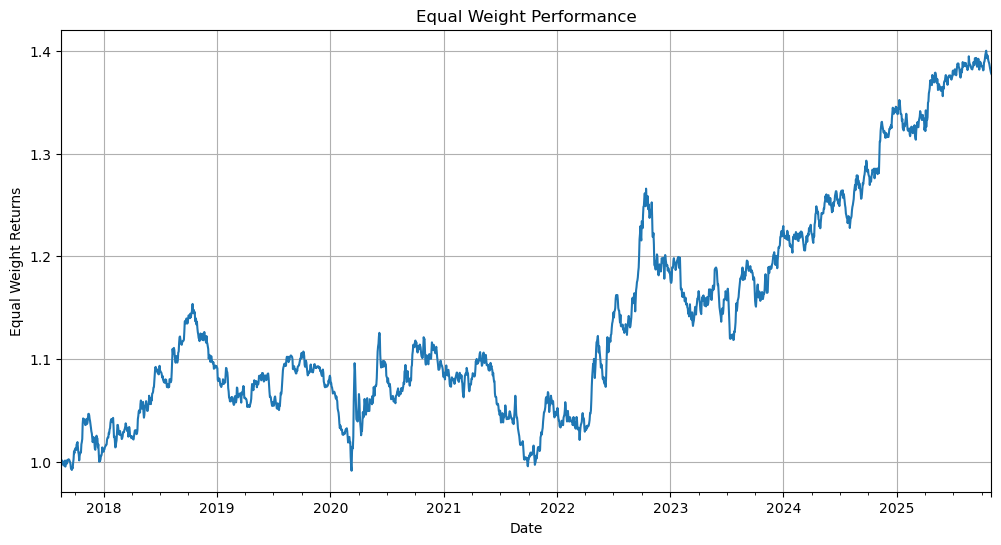

In [99]:
cost_bps_roundtrip = 2.0
ret_panel = fx_ret_aligned[pairs].reindex(pred_df.index)
pos = np.sign(pred_df).replace(0, 0.0)
w   = pos.div(pos.abs().sum(axis=1), axis=0).fillna(0.0)

strategy_pnl_gross = (w * ret_panel).sum(axis=1)

alloc      = w
turnover   = alloc.diff().abs().sum(axis=1).fillna(0.0)
trade_cost = turnover * (cost_bps_roundtrip / 10_000.0)

strategy_pnl_net = strategy_pnl_gross - trade_cost
pnl_df = pd.DataFrame({
    "strategy_pnl_gross": strategy_pnl_gross,
    "turnover": turnover,
    "trade_cost": trade_cost,
    "strategy_pnl": strategy_pnl_net,           
}).dropna()

print_metrics(pnl_df, "Equal-Weight")

pnl_df["equity"] = (1 + pnl_df["strategy_pnl"]).cumprod()
pnl_df['equity'].plot(figsize=(12, 6), color="tab:blue", title="Equal Weight Performance")
plt.ylabel('Equal Weight Returns')
plt.grid(True)
plt.show()


--- Equal-Weight (OS: 2023–) Metrics ---
Period: 2023-01-02 to 2025-10-31
Total Return:  23.26%
CAGR:  7.38%
Sharpe (ann.):  1.28
Max Drawdown: -5.17%
Win Rate:  51.49%


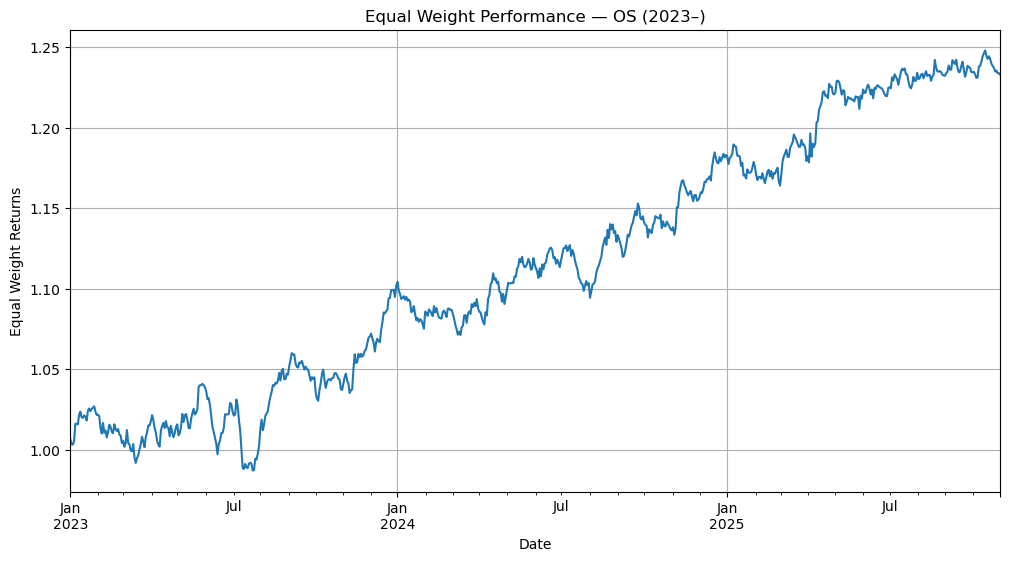

In [78]:
# --- Params ---
cost_bps_roundtrip = 2.0
start_os = "2023-01-01"   # backtest only after 2022-12-31

# --- Align and slice OS window ---
idx = fx_ret_aligned.index.intersection(pred_df.index)
ret_full  = fx_ret_aligned.loc[idx, pairs]
pred_full = pred_df.loc[idx, pairs]

ret_panel = ret_full.loc[start_os:]
pred_os   = pred_full.loc[start_os:]

# --- Equal-weight-by-signal positions ---
pos = np.sign(pred_os).replace(0, 0.0)
w   = pos.div(pos.abs().sum(axis=1), axis=0).fillna(0.0)

# --- PnL, turnover, costs (OS only) ---
strategy_pnl_gross = (w * ret_panel).sum(axis=1)

alloc      = w
turnover   = alloc.diff().abs().sum(axis=1).fillna(0.0)
trade_cost = turnover * (cost_bps_roundtrip / 10_000.0)

strategy_pnl_net = strategy_pnl_gross - trade_cost

pnl_df = pd.DataFrame({
    "strategy_pnl_gross": strategy_pnl_gross,
    "turnover":           turnover,
    "trade_cost":         trade_cost,
    "strategy_pnl":       strategy_pnl_net,
}).dropna()

print_metrics(pnl_df, "Equal-Weight (OS: 2023–)")

pnl_df["equity"] = (1 + pnl_df["strategy_pnl"]).cumprod()

# --- Plot ---
ax = pnl_df["equity"].plot(figsize=(12, 6), color="tab:blue", title="Equal Weight Performance — OS (2023–)")
ax.set_ylabel("Equal Weight Returns")
ax.grid(True)
plt.show()


--- Individual Metrics Individual (net) ---


,Sharpe,MaxDD%,Win%
pair,,,
AUDUSD,0.41,-15.34,49.72
CADUSD,0.56,-17.43,50.00
NOKUSD,0.72,-20.96,49.91
ZARUSD,0.65,-22.02,48.55


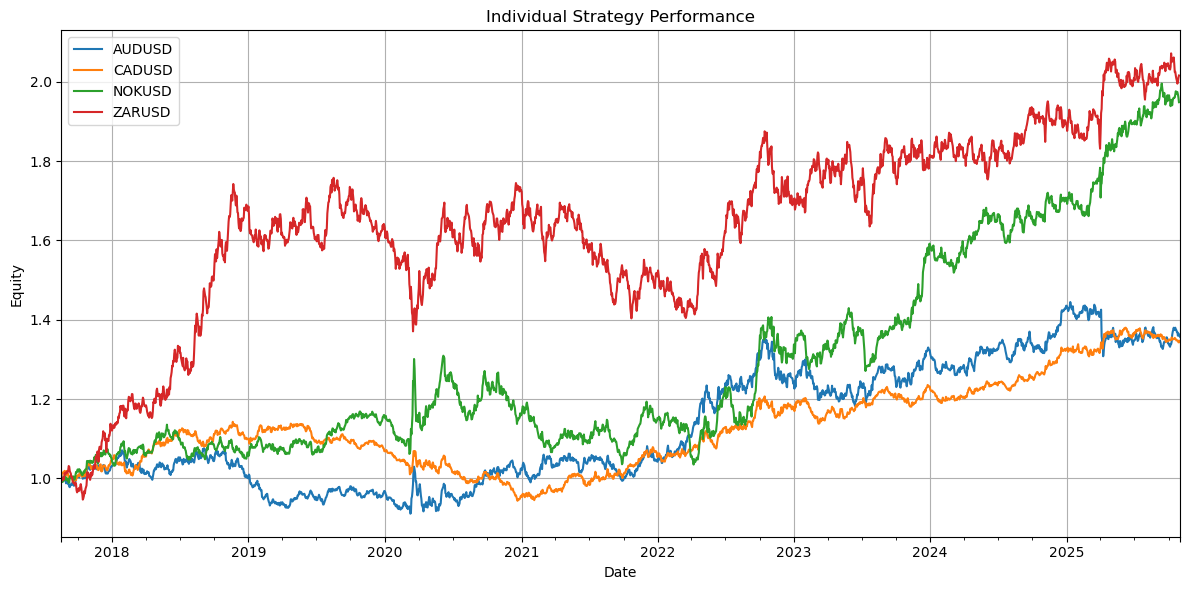

In [72]:
# Individual Performance
def individual_curves(pred_df: pd.DataFrame,
                      returns_df: pd.DataFrame,
                      cost_bps_roundtrip: float = 2.0):
    """
    Per-pair equity from sign(pred). Costs applied per pair from turnover of positions.
    No vol targeting here (this is 'individual performance').
    """
    pred_df, returns_df = pred_df.align(returns_df, join="inner", axis=0)

    pos = np.sign(pred_df).replace(0, 0.0)

    turnover = pos.diff().abs().fillna(0.0)      
    cost_per_unit = cost_bps_roundtrip / 10_000.0
    trade_cost = turnover * cost_per_unit

    pnl_gross = pos * returns_df
    pnl_net = pnl_gross - trade_cost

    equity = (1 + pnl_net).cumprod()

    return pnl_net, equity

def print_individual_metrics(pnl_df: pd.DataFrame, title=""):
    print(f"\n--- {title} Individual (net) ---")
    rows = []
    for c in pnl_df.columns:
        s = pnl_df[c].dropna()
        if s.empty or s.std()==0: 
            rows.append((c, np.nan, np.nan, np.nan)); continue
        sr = (s.mean()/s.std()) * np.sqrt(252)
        eq = (1+s).cumprod()
        mdd = (eq/eq.cummax()-1).min()
        hit = (s>0).mean()
        rows.append((c, sr, 100*mdd, 100*hit))
    out = pd.DataFrame(rows, columns=["pair","Sharpe","MaxDD%","Win%"]).set_index("pair")
    display(out.round(2))

def plot_individual_equity(equity_df: pd.DataFrame, title=""):
    fig, ax = plt.subplots(figsize=(12,6))
    for c in equity_df.columns:
        equity_df[c].plot(ax=ax, label=c)
    ax.set_title(title)
    ax.set_ylabel("Equity")
    ax.grid(True)
    ax.legend(loc="upper left")
    plt.tight_layout()


pnl_test_ind, eq_test_ind = individual_curves(pred_df, ret_panel, cost_bps_roundtrip=2.0)
print_individual_metrics(pnl_test_ind, title="Individual Metrics")
plot_individual_equity(eq_test_ind, title="Individual Strategy Performance")

## Advanced: Vol-Targeted

In [73]:
def vol_target_portfolio(pred_df: pd.DataFrame,
                         returns_df: pd.DataFrame,
                         target_ann_vol: float = 0.10,
                         vol_window: int = 63,
                         cap_scalar: float = 3.0,
                         cost_bps_roundtrip: float = 2.0):
    
    pred_df, returns_df = pred_df.align(returns_df, join="inner", axis=0)

    pos = np.sign(pred_df).replace(0, 0.0)
    w = pos.div(pos.abs().sum(axis=1), axis=0).fillna(0.0)

    raw_pnl = (w * returns_df).sum(axis=1)

    roll_sigma = raw_pnl.rolling(vol_window).std()
    scalar = (target_ann_vol / (roll_sigma * np.sqrt(252))).clip(0, cap_scalar).shift(1).fillna(0.0)

    alloc = w.mul(scalar, axis=0)
    turnover = alloc.diff().abs().sum(axis=1).fillna(0.0)
    cost_per_unit = cost_bps_roundtrip / 10_000.0
    trade_cost = turnover * cost_per_unit

    vt_pnl_gross = raw_pnl * scalar
    vt_pnl_net = vt_pnl_gross - trade_cost

    equity_net = (1 + vt_pnl_net).cumprod()

    return pd.DataFrame({
        "raw_pnl": raw_pnl,
        "scalar": scalar,
        "turnover": turnover,
        "trade_cost": trade_cost,
        "vt_pnl_gross": vt_pnl_gross,
        "vt_pnl_net": vt_pnl_net,
        "equity_net": equity_net
    })

In [74]:
ret_panel = fx_ret_aligned[pairs].reindex(pred_df.index)
res = vol_target_portfolio(pred_df, ret_panel, target_ann_vol=0.25, vol_window=42, cap_scalar=1.0, cost_bps_roundtrip=2.0)


--- Overall Training IS Metrics ---
Period: 2017-08-17 to 2025-10-31
Total Return:  70.93%
CAGR:  6.51%
Sharpe (ann.):  1.02
Max Drawdown: -9.85%
Win Rate:  49.81%


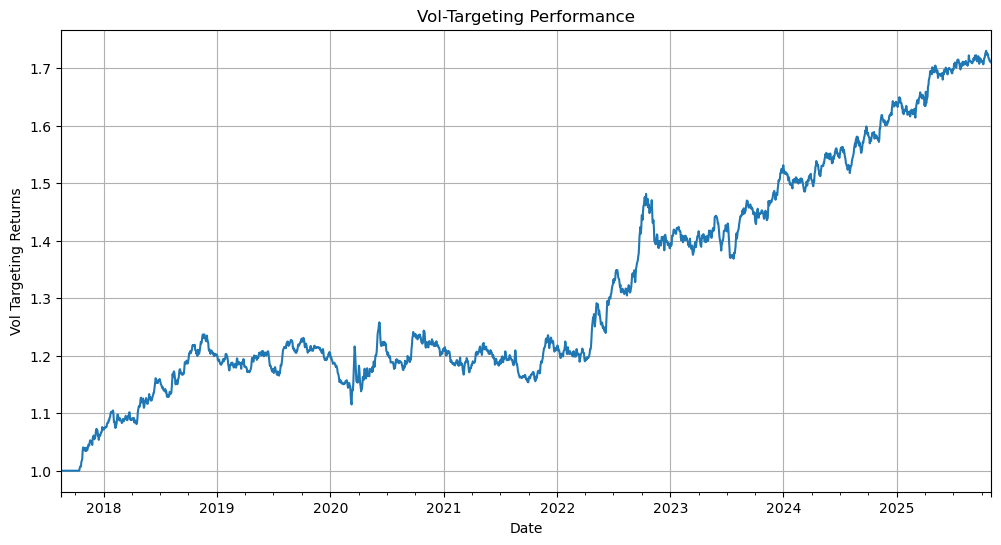

In [75]:
pnl_df = pd.DataFrame(res).dropna()
pnl_df['strategy_pnl'] = pnl_df['vt_pnl_net']

print_metrics(pnl_df, "Overall Training IS")

# Visulization
pnl_df['equity_net'].plot(figsize=(12, 6), color="tab:blue", title="Vol-Targeting Performance")
plt.ylabel('Vol Targeting Returns')
plt.grid(True)
plt.show()


--- Individual Metrics Individual (net) ---


,Sharpe,MaxDD%,Win%
pair,,,
AUDUSD,0.41,-15.34,48.79
CADUSD,0.56,-17.43,49.02
NOKUSD,0.73,-20.96,49.11
ZARUSD,0.70,-22.02,47.80


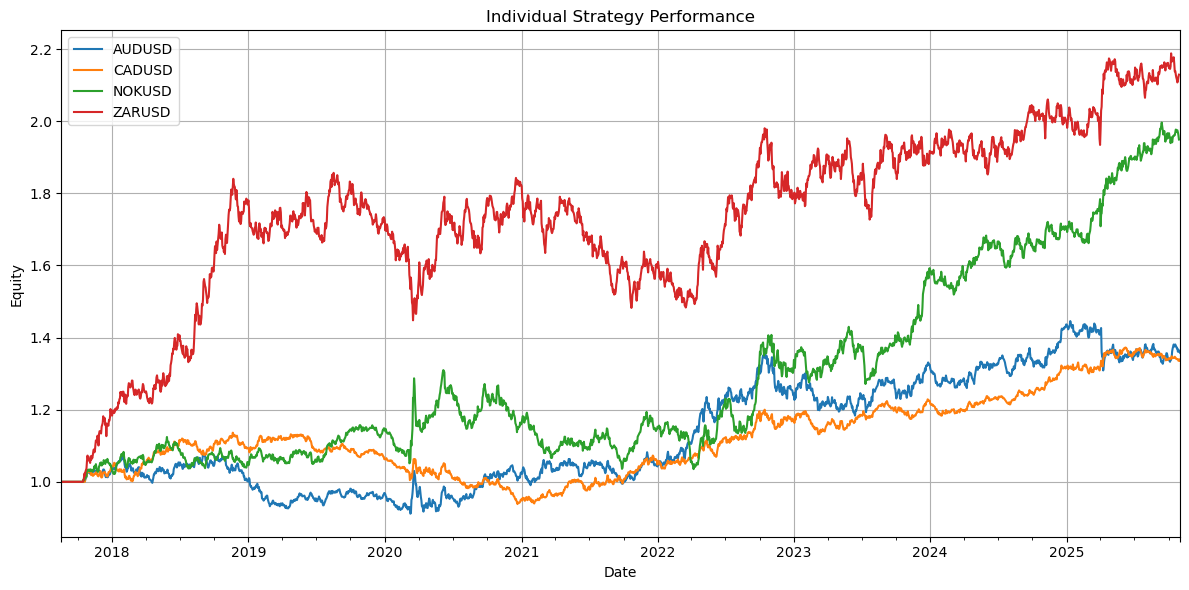

In [76]:
def individual_vol_target_curves(pred_df: pd.DataFrame,
                                 returns_df: pd.DataFrame,
                                 target_ann_vol: float = 0.10,
                                 vol_window: int = 63,
                                 cap_scalar: float = 3.0,
                                 cost_bps_roundtrip: float = 2.0):

    pred_df, returns_df = pred_df.align(returns_df, join="inner", axis=0)

    pairs = [c for c in pred_df.columns if c in returns_df.columns]
    vt_pnl_net = pd.DataFrame(index=pred_df.index, columns=pairs, dtype=float)
    equity     = pd.DataFrame(index=pred_df.index, columns=pairs, dtype=float)
    scalar     = pd.DataFrame(index=pred_df.index, columns=pairs, dtype=float)
    turnover   = pd.DataFrame(index=pred_df.index, columns=pairs, dtype=float)
    trade_cost = pd.DataFrame(index=pred_df.index, columns=pairs, dtype=float)

    cost_per_unit = cost_bps_roundtrip / 10_000.0

    for c in pairs:
        pos = np.sign(pred_df[c]).replace(0, 0.0)
        raw_pnl = pos * returns_df[c]

        roll_sigma = raw_pnl.rolling(vol_window).std()

        s = (target_ann_vol / (roll_sigma * np.sqrt(252))).clip(0, cap_scalar).shift(1).fillna(0.0)

        alloc = pos * s
        to    = alloc.diff().abs().fillna(0.0)
        cost  = to * cost_per_unit

        pnl_gross = raw_pnl * s
        pnl_net   = pnl_gross - cost
        eq        = (1 + pnl_net).cumprod()

        scalar[c]     = s
        turnover[c]   = to
        trade_cost[c] = cost
        vt_pnl_net[c] = pnl_net
        equity[c]     = eq

    return {"vt_pnl_net": vt_pnl_net, "equity": equity,
            "scalar": scalar, "turnover": turnover, "trade_cost": trade_cost}

res_ind = individual_vol_target_curves(pred_df, ret_panel,
                                      target_ann_vol=0.25, vol_window=42,
                                      cap_scalar=1.0, cost_bps_roundtrip=2.0)

print_individual_metrics(res_ind['vt_pnl_net'], title="Individual Metrics")
plot_individual_equity(res_ind['equity'], title="Individual Strategy Performance")

# 5. Diagnostics

## 5.1 Baseline Strategy

Baseline return metrics — Sharpe: -0.19, MaxDD: -29.15%


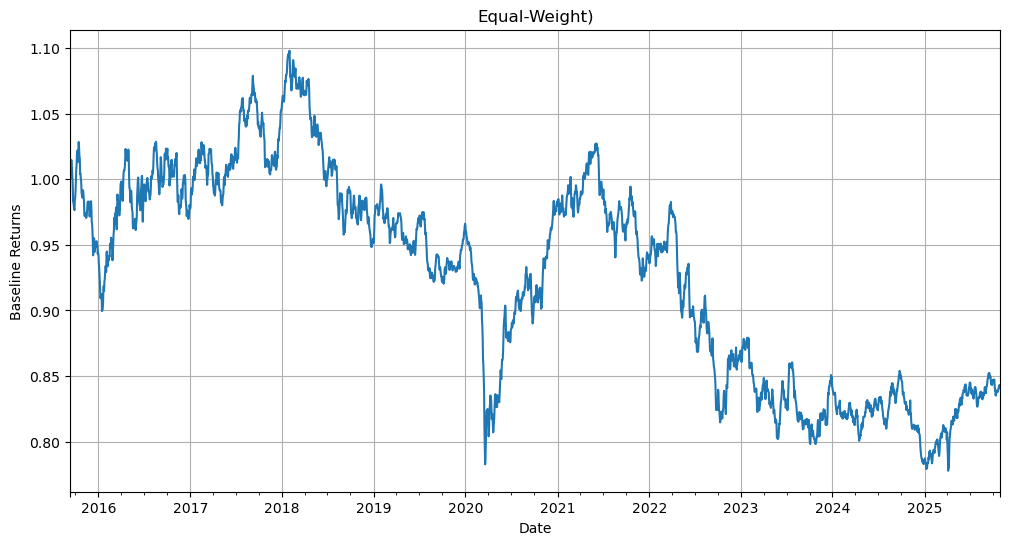

In [77]:
def quick_metrics(pnl, label):
    pnl = pnl.dropna()
    sr = 0 if pnl.std()==0 else (pnl.mean()/pnl.std())*np.sqrt(252)
    eq = (1+pnl).cumprod()
    mdd = (eq/eq.cummax()-1).min()*100
    print(f"{label} — Sharpe: {sr:.2f}, MaxDD: {mdd:.2f}%")

pairs = ["NOKUSD","AUDUSD","CADUSD","ZARUSD"]

ret_panel = fx_ret_aligned[pairs].dropna(how="any")

w_eq = pd.Series(1.0/len(pairs), index=pairs)
baseline_pnl = (ret_panel * w_eq).sum(axis=1)
baseline_eq  = (1 + baseline_pnl).cumprod()

quick_metrics(baseline_pnl, "Baseline return metrics")

baseline_eq.plot(figsize=(12, 6), color="tab:blue", title="Equal-Weight)")
plt.ylabel('Baseline Returns')
plt.grid(True)
plt.show()